# Area sampling using Dask and Xarray
Computational improvement based on test_area_sample_PETandLtheta.ipynb

In [21]:
from dask.distributed import Client
import xarray as xr
import numpy as np
from datetime import datetime
import os
import rasterio as rio
import glob
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

In [3]:
###### Define constants ###########

# Changable

# Area
network_name = "California"
minx = -124.5
miny = 32.5
maxx = -114
maxy = 42.5
bbox = {'minx':minx, 'maxx':maxx, 'miny':miny, 'maxy':maxy}

# Chunks
chunks = {'x': 100, 'y': 100}

# Thresholds
lower_quantile_thresh = 0.25
upper_quantile_thresh = 0.75
precip_thresh = 0.00002

# Dates
startDate = datetime(2016, 1, 1)
endDate = datetime(2017, 1, 1)


# Non-changable
SMAPL4_times = ['0130', '0430', '0730', '1030', '1330', '1630', '1930', '2230'] # 3-hourly data

###### PATH ###########
input_path = r"..\1_data"
output_path = r"..\3_data_out"
SMAPL3_path = "SPL3SMP_E"
SMAPL4_path = "SPL4SMGP"
SMAPL4_grid_path = "SMAPL4SMGP_EASEreference"
PET_path = "PET"

In [4]:
client = Client(n_workers=10, threads_per_worker=5, memory_limit='16GB')
client
# See https://distributed.dask.org/en/stable/client.html

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 10
Total threads: 50,Total memory: 149.01 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:56425,Workers: 10
Dashboard: http://127.0.0.1:8787/status,Total threads: 50
Started: Just now,Total memory: 149.01 GiB
Comm: tcp://127.0.0.1:56456,Total threads: 5
Dashboard: http://127.0.0.1:56459/status,Memory: 14.90 GiB
Nanny: tcp://127.0.0.1:56428,


## Read data 

### Read SMAP L4 data

In [5]:
def _preprocess_SMAPL4(ds):
    # Assign missing time dimension
    startTime = datetime.strptime(ds.rangeBeginningDateTime.split(".")[0], '%Y-%m-%dT%H:%M:%S')
    endTime = datetime.strptime(ds.rangeEndingDateTime.split(".")[0], '%Y-%m-%dT%H:%M:%S')
    midTime = startTime + (startTime - endTime)/2
    ds = ds.assign_coords(time=midTime)
    return ds

# https://stackoverflow.com/questions/65376109/use-xarray-open-mfdataset-on-files-with-no-time-dimension-included

In [113]:
# Get a list of files 

SMAPL4_fn_pattern = f'SMAP_L4_SM_gph_{startDate.year}010*.nc' ####### CHNAGE LATER: testing with 2016 Jan 1-9 data ####### 
SMAPL4_file_paths = glob.glob(rf'{input_path}/{SMAPL4_path}/{SMAPL4_fn_pattern}')

# Load data
ds_SMAPL4 = xr.open_mfdataset(SMAPL4_file_paths, engine="rasterio", preprocess=_preprocess_SMAPL4, chunks=chunks, combine='nested', concat_dim='time', parallel=True)

# TODO/ISSUE #1: I need to use engine="rasterio" which takes x5 times than engine="netcdf4" (40sec to read 1 mo of data )
# Otherwise, precipitation variable is not read. 
# This is probably because precipitation variable is stored one level below of all other variables (lat, lon, etc.)

# TODO/ISSUE #2: For both L3 and L4 data, Y axis is read upside down, so I need to reset the index.
# Currently the precipitation mask is obtained by flipping np.array vertically (need to load all the data in the array) 
# -> use apply_ufunc() for this operation? 

# Debug attempt 1: 
# ds_SMAPL4 = ds_SMAPL4.reindex(y=ds_SMAPL4.y*(-1))
# The chunking over the y axis disappers. Plus, numeric values within precipitation data disappears
# Debug attempt 2: 
# ds_SMAPL4_P = ds_SMAPL4_P.isel(y=slice(None, -1))
# This just select the values and does not change the dimension values
# Debug attempt 3: 
# ds_SMAPL4_P = ds_SMAPL4_P.reindex_like(SMAPL4)
# Numeric values within precipitation data disappears

# TODO/IMPROVEMENT #3: open_mfdataset(parallel=True) is not really making things super fast. Need to otimize Clients

# # https://docs.xarray.dev/en/stable/generated/xarray.open_mfdataset.html#xarray.open_mfdataset

<xarray.Dataset>
Dimensions:                           (band: 1, x: 3856, y: 1822, time: 72)
Coordinates:
  * band                              (band) int32 1
  * x                                 (x) float64 -180.0 -179.9 ... 179.9 180.0
  * y                                 (y) float64 -85.01 -84.92 ... 84.9 85.0
    projection_information            int32 0
  * time                              (time) datetime64[ns] 2015-12-31T22:30:...
Data variables:
    cell_column                       (time, band, y, x) float64 dask.array<chunksize=(1, 1, 22, 100), meta=np.ndarray>
    cell_lat                          (time, band, y, x) float32 dask.array<chunksize=(1, 1, 22, 100), meta=np.ndarray>
    cell_lon                          (time, band, y, x) float32 dask.array<chunksize=(1, 1, 22, 100), meta=np.ndarray>
    cell_row                          (time, band, y, x) float64 dask.array<chunksize=(1, 1, 22, 100), meta=np.ndarray>
    precipitation_total_surface_flux  (time, band, y, x) float32 dask.array<chunksize=(1, 1, 22, 100), meta=np.ndarray>
Attributes: (12/201)
    antennaRotationRate:                13
    description:                        The observation-corrected surface met...
    identifier:                         GEOS5COR
    edition:                            JPL CL#14-2285, JPL 400-1567
    publicationDate:                    2014-07-01
    title:                              SMAP Handbook
    ...                                 ...
    grid_rows:                          1822
    History:                            File written by ldas2daac.x
    Institution:                        NASA Global Modeling and Assimilation...
    References:                         see SMAP L4_SM Product Specification ...
    Source:                             v17.11.1
    Title:                              SMAP L4_SM Geophysical (GPH) Data Gra...

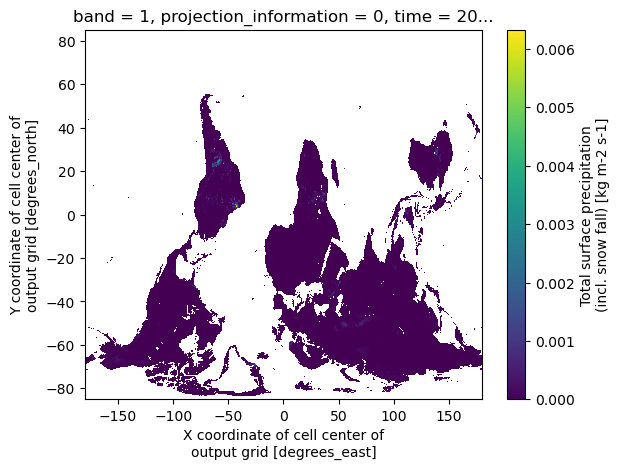

In [114]:
ds_SMAPL4 = ds_SMAPL4.isel(y=slice(None, None, -1))
ds_SMAPL4.precipitation_total_surface_flux.sel(time='2016-01-01 01:30:00').plot()
ds_SMAPL4

<xarray.Dataset>
Dimensions:                           (band: 1, x: 113, y: 107, time: 72)
Coordinates:
  * band                              (band) int32 1
  * x                                 (x) float64 -124.5 -124.4 ... -114.0
  * y                                 (y) float64 -42.44 -42.35 ... -32.54
    projection_information            int32 0
  * time                              (time) datetime64[ns] 2015-12-31T22:30:...
Data variables:
    cell_column                       (time, band, y, x) float64 dask.array<chunksize=(1, 1, 66, 6), meta=np.ndarray>
    cell_lat                          (time, band, y, x) float32 dask.array<chunksize=(1, 1, 66, 6), meta=np.ndarray>
    cell_lon                          (time, band, y, x) float32 dask.array<chunksize=(1, 1, 66, 6), meta=np.ndarray>
    cell_row                          (time, band, y, x) float64 dask.array<chunksize=(1, 1, 66, 6), meta=np.ndarray>
    precipitation_total_surface_flux  (time, band, y, x) float32 dask.array<chunksize=(1, 1, 66, 6), meta=np.ndarray>
Attributes: (12/201)
    antennaRotationRate:                13
    description:                        The observation-corrected surface met...
    identifier:                         GEOS5COR
    edition:                            JPL CL#14-2285, JPL 400-1567
    publicationDate:                    2014-07-01
    title:                              SMAP Handbook
    ...                                 ...
    grid_rows:                          1822
    History:                            File written by ldas2daac.x
    Institution:                        NASA Global Modeling and Assimilation...
    References:                         see SMAP L4_SM Product Specification ...
    Source:                             v17.11.1
    Title:                              SMAP L4_SM Geophysical (GPH) Data Gra...

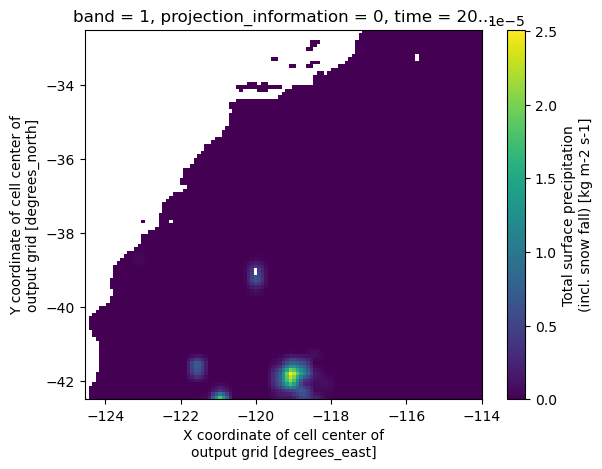

In [124]:
ds_SMAPL4_clipped = ds_SMAPL4.sel(x=slice(minx, maxx), y=slice(maxy*(-1), miny*(-1)))
ds_SMAPL4_clipped.sel(time='2016-01-01 01:30:00').precipitation_total_surface_flux.plot()
ds_SMAPL4_clipped

### Read SMAP L3 data

In [9]:
def _preprocess_SMAPL3(ds):
    # Assign missing time dimension
    # Doesn't care about hour amd minutes, as it is daily data
    startTime = datetime.strptime(ds.rangeBeginningDateTime.split("T")[0], '%Y-%m-%d')
    ds = ds.assign_coords(time=startTime)
    return ds

In [10]:
# Get a list of files 
# Test with 2016 Jan 1-9 data first
SMAPL3_fn_pattern = f'SMAP_L3_SM_P_E_{startDate.year}010*.nc' ####### CHNAGE LATER: testing with 2016 Jan 1-9 data #######
SMAPL3_file_paths = glob.glob(rf'{input_path}/{SMAPL3_path}/{SMAPL3_fn_pattern}')
# Load data
ds_SMAPL3 = xr.open_mfdataset(SMAPL3_file_paths, preprocess=_preprocess_SMAPL3, engine="rasterio", chunks=chunks, combine="nested", concat_dim="time")

In [14]:
ds_SMAPL3_clipped = ds_SMAPL3.sel(x=slice(minx, maxx), y=slice(maxy, miny))
ds_SMAPL3_clipped
# 3.3 sec for 1 mo of data

<xarray.Dataset>
Dimensions:                 (band: 1, x: 113, y: 107, time: 9)
Coordinates:
  * band                    (band) int32 1
  * x                       (x) float64 -124.5 -124.4 -124.3 ... -114.1 -114.0
  * y                       (y) float64 42.43 42.33 42.24 ... 32.72 32.62 32.53
    /crs                    int32 0
  * time                    (time) datetime64[ns] 2016-01-01 ... 2016-01-09
Data variables:
    EASE_column_index       (time, band, y, x) float32 dask.array<chunksize=(1, 1, 44, 6), meta=np.ndarray>
    longitude_pm            (time, band, y, x) float32 dask.array<chunksize=(1, 1, 44, 6), meta=np.ndarray>
    retrieval_qual_flag_pm  (time, band, y, x) float32 dask.array<chunksize=(1, 1, 44, 6), meta=np.ndarray>
    soil_moisture_pm        (time, band, y, x) float32 dask.array<chunksize=(1, 1, 44, 6), meta=np.ndarray>
    EASE_row_index          (time, band, y, x) float32 dask.array<chunksize=(1, 1, 44, 6), meta=np.ndarray>
    latitude                (time, band, y, x) float32 dask.array<chunksize=(1, 1, 44, 6), meta=np.ndarray>
    longitude               (time, band, y, x) float32 dask.array<chunksize=(1, 1, 44, 6), meta=np.ndarray>
    retrieval_qual_flag     (time, band, y, x) float32 dask.array<chunksize=(1, 1, 44, 6), meta=np.ndarray>
    soil_moisture           (time, band, y, x) float32 dask.array<chunksize=(1, 1, 44, 6), meta=np.ndarray>
    EASE_column_index_pm    (time, band, y, x) float32 dask.array<chunksize=(1, 1, 44, 6), meta=np.ndarray>
    EASE_row_index_pm       (time, band, y, x) float32 dask.array<chunksize=(1, 1, 44, 6), meta=np.ndarray>
    latitude_pm             (time, band, y, x) float32 dask.array<chunksize=(1, 1, 44, 6), meta=np.ndarray>
Attributes: (12/82)
    antennaRotationRate:                  14.6
    description:                          A configuration file generated auto...
    identifier:                           L3_SM_P_E_SPS
    edition:                              1.0
    publicationDate:                      2013-02-08
    title:                                Product Specification Document for ...
    ...                                   ...
    identifier_product_DOI:               doi:10.5067/4DQ54OUIJ9DL
    longName:                             SMAP Enhanced L3 Radiometer Global ...
    mission:                              SMAP
    pointOfContact:                       National Snow and Ice Data Center
    resourceProviderOrganizationName:     National Aeronautics and Space Admi...
    revisionDate:                         2021-08-31

<xarray.DataArray 'soil_moisture' (time: 9, band: 1, y: 107, x: 113)>
dask.array<getitem, shape=(9, 1, 107, 113), dtype=float32, chunksize=(1, 1, 63, 100), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) int32 1
  * x        (x) float64 -124.5 -124.4 -124.3 -124.2 ... -114.2 -114.1 -114.0
  * y        (y) float64 42.43 42.33 42.24 42.15 ... 32.81 32.72 32.62 32.53
    /crs     int32 0
  * time     (time) datetime64[ns] 2016-01-01 2016-01-02 ... 2016-01-09
Attributes: (12/32)
    /Soil_Moisture_Retrieval_Data_AM/soil_moisture#coordinates:       /Soil_M...
    /Soil_Moisture_Retrieval_Data_AM/soil_moisture#DIMENSION_LABELS:  {y,x}
    /Soil_Moisture_Retrieval_Data_AM/soil_moisture#grid_mapping:      /crs
    /Soil_Moisture_Retrieval_Data_AM/soil_moisture#long_name:         Represe...
    /Soil_Moisture_Retrieval_Data_AM/soil_moisture#units:             cm**3/c...
    /Soil_Moisture_Retrieval_Data_AM/soil_moisture#valid_max:         0.5
    ...                                                               ...
    coordinates:                                                      /Soil_M...
    DIMENSION_LABELS:                                                 {y,x}
    long_name:                                                        Represe...
    units:                                                            cm**3/c...
    valid_max:                                                        0.5
    valid_min:                                                        0.02

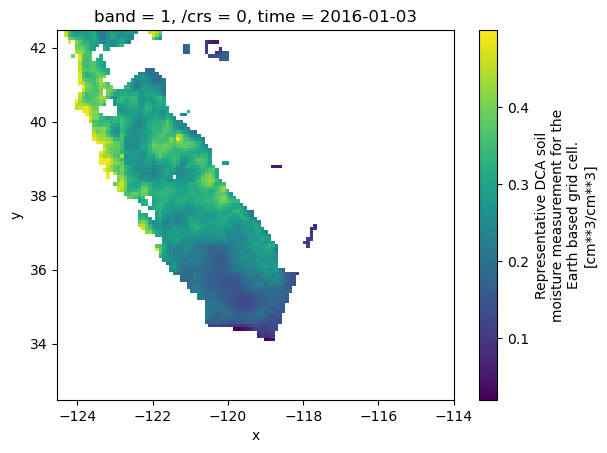

In [17]:
ds_SMAPL3_clipped.sel(time='2016-01-03').soil_moisture.plot()
ds_SMAPL3_clipped.soil_moisture
# TODO/IMPROVEMENT: Add dropna(how=all) somewhere to skip calculation of the ocean etc.

### Read Singer PET data

In [18]:
# Get a list of files 
PET_fn_pattern = f'*_daily_pet.nc'
PET_file_paths = glob.glob(rf'{input_path}/{PET_path}/{PET_fn_pattern}')

# Load data
ds_PET = xr.open_mfdataset(PET_file_paths, combine="nested", chunks=chunks, concat_dim="time", parallel=True)
# ds_PET = xr.open_mfdataset(PET_file_paths, combine="by_coords", chunks=chunks, parallel=True)
ds_PET

<xarray.Dataset>
Dimensions:    (time: 2557, latitude: 1801, longitude: 3600)
Coordinates:
  * time       (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2021-12-31
  * latitude   (latitude) float32 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * longitude  (longitude) float32 -180.0 -179.9 -179.8 ... 179.7 179.8 179.9
Data variables:
    pet        (time, latitude, longitude) float32 dask.array<chunksize=(365, 1801, 3600), meta=np.ndarray>

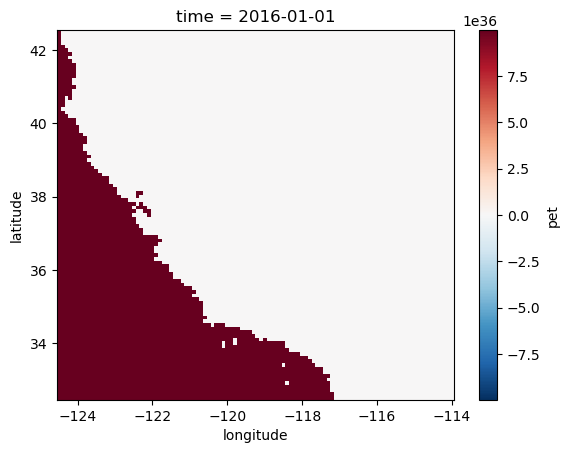

In [19]:
ds_PET_clipped = ds_PET.sel(longitude=slice(minx, maxx), latitude=slice(maxy, miny)).copy()
ds_PET_clipped.pet.sel(time='2016-01-01').plot()

## Processing data

### Get daily mean values

In [125]:
# SMAP L4
daily_P = ds_SMAPL4_clipped.precipitation_total_surface_flux.resample(time='D', skipna=True, keep_attrs=True).mean('time')

# SMAP L3
# Mask low-quality data
ds_SMAPL3_clipped['soil_moisture_am_masked'] = ds_SMAPL3_clipped.soil_moisture.where((ds_SMAPL3.retrieval_qual_flag == 0) | (ds_SMAPL3.retrieval_qual_flag == 8))
ds_SMAPL3_clipped['soil_moisture_pm_masked'] = ds_SMAPL3_clipped.soil_moisture_pm.where((ds_SMAPL3.retrieval_qual_flag_pm == 0) | (ds_SMAPL3.retrieval_qual_flag_pm == 8))
stacked_data = ds_SMAPL3_clipped[['soil_moisture_am_masked', 'soil_moisture_pm_masked']].to_array(dim='new_dim')
ds_SMAPL3_clipped['soil_moisture_daily'] = stacked_data.mean(skipna=True, dim="new_dim")

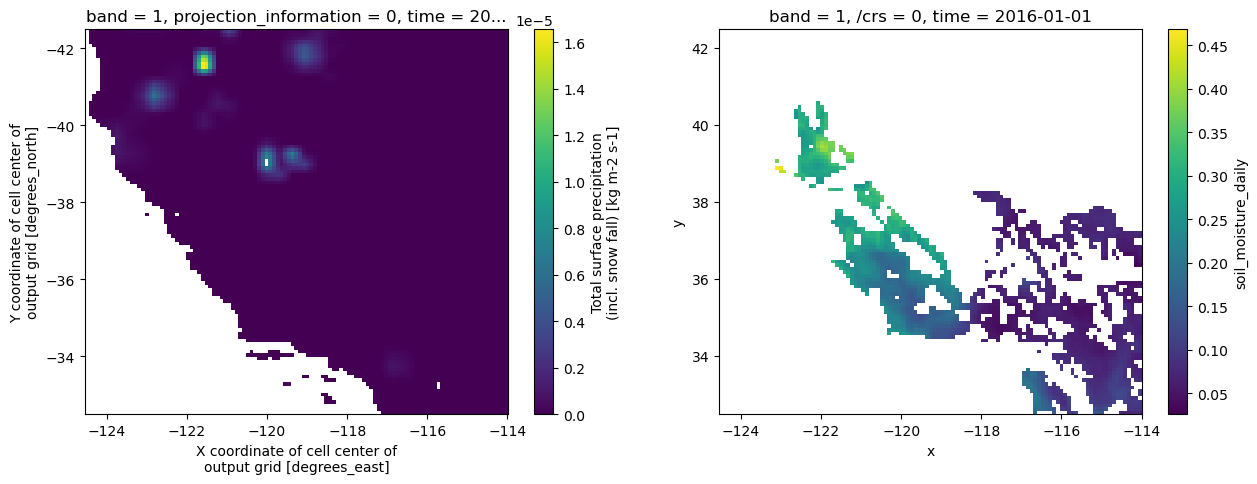

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
daily_P.sel(time='2016-01-01').plot(ax=ax1)
ax1.invert_yaxis()
ds_SMAPL3_clipped.soil_moisture_daily.sel(time='2016-01-01').plot(ax=ax2)

### Calculate dS/dt

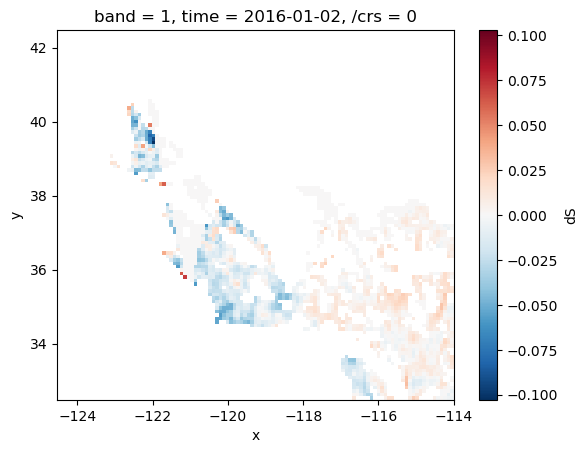

In [26]:
# Calculate dS/dt

# TODO/ISSUE: Don't know how to do this yet. 
# Want to drop data if precipitation is less than 0.00002 & soil moisture data is null
# This is test calculation just to get things done for the latter part ... 

# Forward fill ... but then can't properly calculate dS or masks. 
ds_SMAPL3_clipped['filled_SM'] = ds_SMAPL3_clipped['soil_moisture_daily'].ffill(dim="time", limit=3)
ds_SMAPL3_clipped['dS'] = ds_SMAPL3_clipped['filled_SM'].diff(dim="time")
ds_SMAPL3_clipped['dS'].sel(time='2016-01-02').plot()

# Testing 
# data = [1, 2, 3, 4, np.nan, 5, 6, 7, np.nan, np.nan, 8]
# da = xr.DataArray(data, dims=('index',), coords={'index': range(len(data))})
# print(da)
# print(da.ffill(dim="index"))
# print(da.ffill(dim="index").diff(dim='index'))
# da.where(~np.isnan(da)).diff(dim="index")


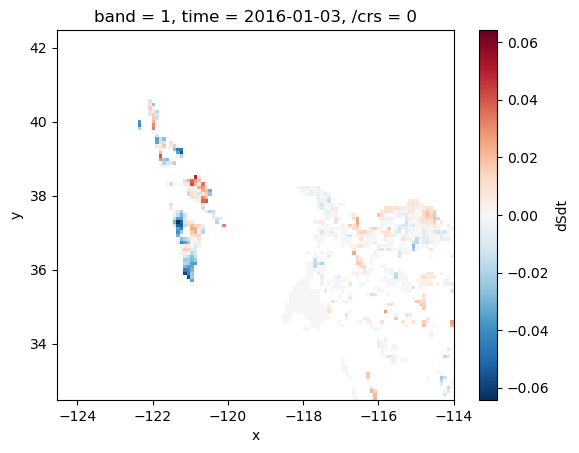

In [27]:
ds_SMAPL3_clipped['isnan_SM'] = ds_SMAPL3_clipped['soil_moisture_daily'].isnull(keep_attrs=True)
ds_SMAPL3_clipped['datagap_SM'] = ds_SMAPL3_clipped['isnan_SM'].rolling(time=3, center=True).sum()
ds_SMAPL3_clipped['dSdt'] = ds_SMAPL3_clipped['dS'] / ds_SMAPL3_clipped['datagap_SM']  # TODO/Fix: dividing by zero
ds_SMAPL3_clipped['dSdt'].sel(time='2016-01-03').plot()

### Mask by precipitation

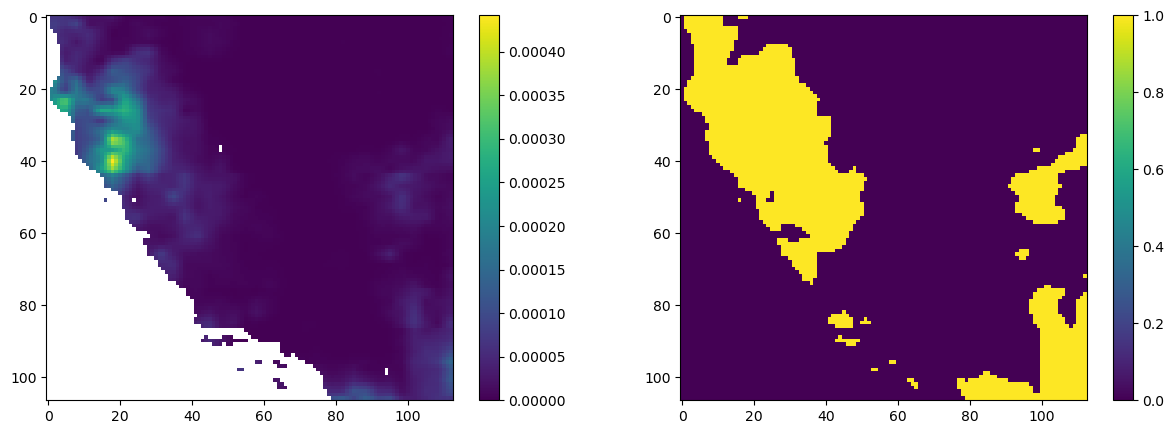

In [133]:
ds_SMAPL4_P = daily_P.load() # np.flip(ds_SMAPL4_clipped.precipitation_total_surface_flux.load(), axis=3)
ds_SMAPL4_P_mask = ds_SMAPL4_P > precip_thresh

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
img1 = ax1.imshow(ds_SMAPL4_P[4][0][:][:])
img2 = ax2.imshow(ds_SMAPL4_P_mask[4][0][:][:])
fig.colorbar(img1, ax=ax1)
fig.colorbar(img2, ax=ax2)
# https://geohackweek.github.io/nDarrays/09-masking/

In [143]:
# Do this in dask apply_ufunc? 
ds_SMAPL4_P_mask.to_numpy()


AttributeError: 'numpy.ndarray' object has no attribute 'reindex_like'

In [30]:
# Can't mask xarray with numpy array? 
ds_SMAPL3_masked = ds_SMAPL3_clipped.where(ds_SMAPL4_P_mask == True) # something like isel? 
ds_SMAPL3_masked

<xarray.Dataset>
Dimensions:                  (time: 0, band: 1, y: 0, x: 113)
Coordinates:
  * band                     (band) int32 1
  * x                        (x) float64 -124.5 -124.4 -124.3 ... -114.1 -114.0
  * y                        (y) float64 
  * time                     (time) datetime64[ns] 
    /crs                     int32 0
    projection_information   int32 0
Data variables: (12/20)
    EASE_column_index        (time, band, y, x) float32 dask.array<chunksize=(0, 1, 0, 6), meta=np.ndarray>
    longitude_pm             (time, band, y, x) float32 dask.array<chunksize=(0, 1, 0, 6), meta=np.ndarray>
    retrieval_qual_flag_pm   (time, band, y, x) float32 dask.array<chunksize=(0, 1, 0, 6), meta=np.ndarray>
    soil_moisture_pm         (time, band, y, x) float32 dask.array<chunksize=(0, 1, 0, 6), meta=np.ndarray>
    EASE_row_index           (time, band, y, x) float32 dask.array<chunksize=(0, 1, 0, 6), meta=np.ndarray>
    latitude                 (time, band, y, x) float32 dask.array<chunksize=(0, 1, 0, 6), meta=np.ndarray>
    ...                       ...
    soil_moisture_daily      (time, band, y, x) float32 dask.array<chunksize=(0, 1, 0, 6), meta=np.ndarray>
    filled_SM                (time, band, y, x) float32 dask.array<chunksize=(0, 1, 0, 6), meta=np.ndarray>
    dS                       (time, band, y, x) float32 dask.array<chunksize=(0, 1, 0, 6), meta=np.ndarray>
    isnan_SM                 (time, band, y, x) float64 dask.array<chunksize=(0, 1, 0, 6), meta=np.ndarray>
    datagap_SM               (time, band, y, x) float64 dask.array<chunksize=(0, 1, 0, 6), meta=np.ndarray>
    dSdt                     (time, band, y, x) float64 dask.array<chunksize=(0, 1, 0, 6), meta=np.ndarray>
Attributes: (12/82)
    antennaRotationRate:                  14.6
    description:                          A configuration file generated auto...
    identifier:                           L3_SM_P_E_SPS
    edition:                              1.0
    publicationDate:                      2013-02-08
    title:                                Product Specification Document for ...
    ...                                   ...
    identifier_product_DOI:               doi:10.5067/4DQ54OUIJ9DL
    longName:                             SMAP Enhanced L3 Radiometer Global ...
    mission:                              SMAP
    pointOfContact:                       National Snow and Ice Data Center
    resourceProviderOrganizationName:     National Aeronautics and Space Admi...
    revisionDate:                         2021-08-31

## Fit regression b/w dS/dt & S for upper/lower PET quantile

### Get upper/lower PET quantile

In [31]:
# Resample PET according to SMAPL3 grid
ds_PET_resampled = ds_PET.sel(longitude=ds_SMAPL3_clipped['x'], latitude=ds_SMAPL3_clipped['y'], method='nearest').copy()
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
# ds_PET.pet.sel(time='2016-01-01').plot(ax=ax1)
# ds_PET_resampled.sel(time='2016-01-01').pet.plot(ax=ax2)

# TODO/ISSUE: The above line takes forever. ds_PET_resampled.sel(time='2016-01-01').pet.load() takes forever as well (like 1min)
# Cannot check the results

In [33]:
# TODO/IMPROVEMENT: Want to mask by ds_SMAPL3_masked['ds'] < 0
ds_SMAPL3_masked = ds_SMAPL3_clipped.sel(band=1)

# ds_PET_resampled.rename({'longitude':'x', 'latitude':'y'})
# print(ds_PET_resampled.pet)
# print(ds_SMAPL3_masked)

In [34]:
# Get PET quantile values 
ds_PET_resampled = ds_PET_resampled.chunk({'time': len(ds_PET_resampled.time), 'x': 'auto', 'y': 'auto'})
ds_quantile = ds_PET_resampled.pet.quantile(dim="time", q=[lower_quantile_thresh, upper_quantile_thresh])
# https://stackoverflow.com/questions/73771129/rechunk-dataarray-to-calculate-90-quantile-over-over-chunked-time-dimension

ds_PET_quantile_upper = ds_PET_resampled.where(ds_PET_resampled.pet >= ds_quantile.sel(quantile=upper_quantile_thresh))
ds_PET_quantile_lower = ds_PET_resampled.where(ds_PET_resampled.pet <= ds_quantile.sel(quantile=lower_quantile_thresh))
print(ds_PET_quantile_upper)
print(ds_PET_quantile_lower)

# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ds_PET_quantile_upper.pet.sel(time='2016-01-01')

# TODO/ISSUE: When I try to load this, it says it's 8GB! WTF. Cannot check the results
# TODO/ISSUE: It's the best if I can merge PET and SMAPL3 data, but dimention error occurs even if I drop/add dimentios 


<xarray.Dataset>
Dimensions:    (time: 2557, y: 107, x: 113)
Coordinates:
  * time       (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2021-12-31
    latitude   (y) float32 dask.array<chunksize=(107,), meta=np.ndarray>
    longitude  (x) float32 dask.array<chunksize=(113,), meta=np.ndarray>
  * x          (x) float64 -124.5 -124.4 -124.3 -124.2 ... -114.2 -114.1 -114.0
    /crs       int32 0
  * y          (y) float64 42.43 42.33 42.24 42.15 ... 32.81 32.72 32.62 32.53
    quantile   float64 0.75
Data variables:
    pet        (time, y, x) float32 dask.array<chunksize=(2557, 107, 113), meta=np.ndarray>
<xarray.Dataset>
Dimensions:    (time: 2557, y: 107, x: 113)
Coordinates:
  * time       (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2021-12-31
    latitude   (y) float32 dask.array<chunksize=(107,), meta=np.ndarray>
    longitude  (x) float32 dask.array<chunksize=(113,), meta=np.ndarray>
  * x          (x) float64 -124.5 -124.4 -124.3 -124.2 ... -114.2 -114.1 -114.0
    /crs      

<xarray.DataArray 'pet' (y: 107, x: 113)>
dask.array<getitem, shape=(107, 113), dtype=float32, chunksize=(107, 113), chunktype=numpy.ndarray>
Coordinates:
    time       datetime64[ns] 2016-01-01
    latitude   (y) float32 dask.array<chunksize=(107,), meta=np.ndarray>
    longitude  (x) float32 dask.array<chunksize=(113,), meta=np.ndarray>
  * x          (x) float64 -124.5 -124.4 -124.3 -124.2 ... -114.2 -114.1 -114.0
    /crs       int32 0
  * y          (y) float64 42.43 42.33 42.24 42.15 ... 32.81 32.72 32.62 32.53
    quantile   float64 0.75

In [35]:
# Get the minimum soil mositure values over the observation period for a given pixel
sm_min = ds_SMAPL3_masked.soil_moisture_daily.min(dim="time")

### Fit regression line

In [ ]:
# TODO/ISSUE: Need to merge PET and SM to get dS/dt for upper and lower quantile of PET 
# ds_PET_quantile_upper

0.056534898


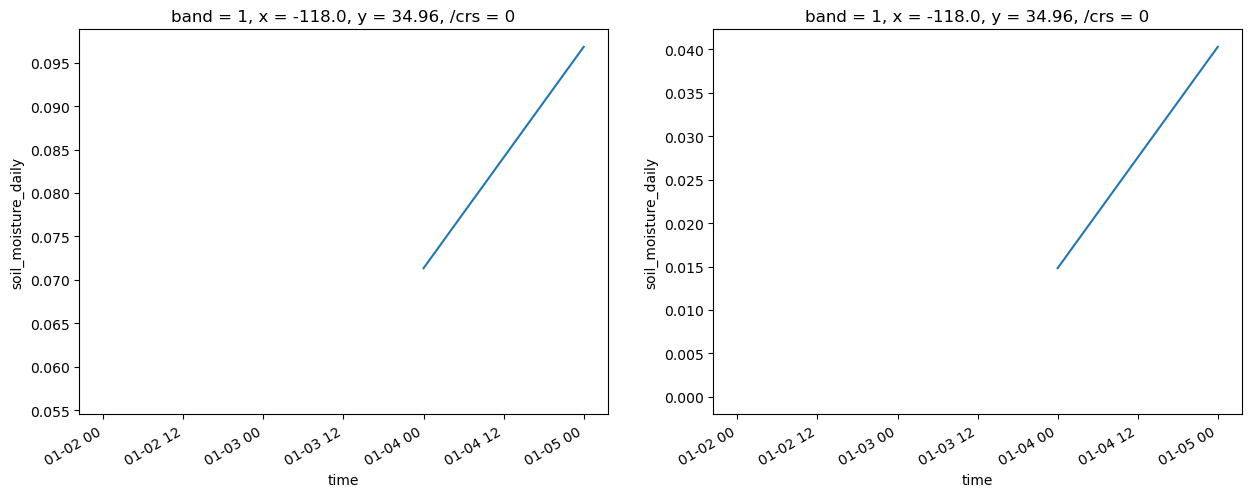

In [103]:
# Shift x values 
# ds_SMAPL3_masked.soil_moisture_daily.sel(time='2016-01-01').plot()

shifted_sm = ds_SMAPL3_masked.soil_moisture_daily - sm_min

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ds_SMAPL3_masked.soil_moisture_daily.sel(x=sample_x, y=sample_y, method='nearest').interp(method='linear').plot(ax=ax1)
shifted_sm.sel(x=sample_x, y=sample_y, method='nearest').interp(method='linear').plot(ax=ax2)
print(sm_min.sel(x=sample_x, y=sample_y, method='nearest').values)


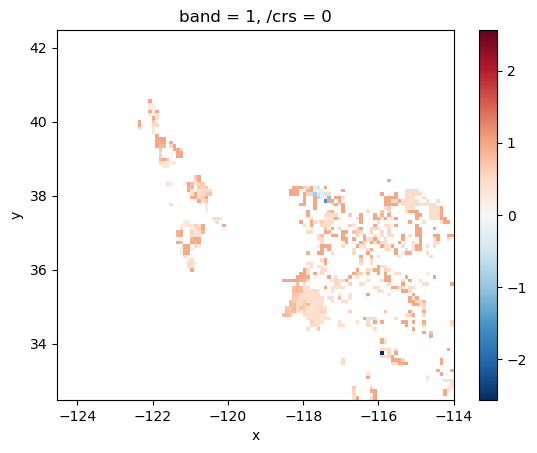

In [74]:
# Fit 
# Regression of linear line through the origin is: a = sum(xi * yi) / sum((xi)^2)
# Proofs in: 
# https://onlinelibrary.wiley.com/doi/10.1111/1467-9639.00136
# http://sites.msudenver.edu/ngrevsta/wp-content/uploads/sites/416/2020/02/Notes_07.pdf

numerator = shifted_sm * ds_SMAPL3_masked.dSdt
denominator = shifted_sm * shifted_sm
denominator_masked = denominator.where((~numerator.isnull()))
a = numerator.sum(dim="time", skipna=True) / denominator_masked.sum(dim="time", skipna=True)
a.plot()

In [101]:
# Plot 
sample_x = -118
sample_y = 35
S = shifted_sm.sel(x=sample_x, y=sample_y, method='nearest').values
dSdt = ds_SMAPL3_masked.dSdt.sel(x=sample_x, y=sample_y, method='nearest').values
S_min = sm_min.sel(x=sample_x, y=sample_y, method='nearest').values
a_sel = a.sel(x=sample_x, y=sample_y, method='nearest').values
print(S)
print(dSdt)
print(S_min)
print(numerator.sel(x=sample_x, y=sample_y, method='nearest').values)
print(denominator.sel(x=sample_x, y=sample_y, method='nearest').values)
print(a_sel)


[       nan 0.                nan 0.01480851 0.04027927        nan
        nan        nan        nan]
[       nan        nan 0.         0.01480851 0.02547076 0.
 0.         0.                nan]
0.056534898
[       nan        nan        nan 0.00021929 0.00102594        nan
        nan        nan        nan]
[       nan 0.                nan 0.00021929 0.00162242        nan
        nan        nan        nan]
0.6761295447689161


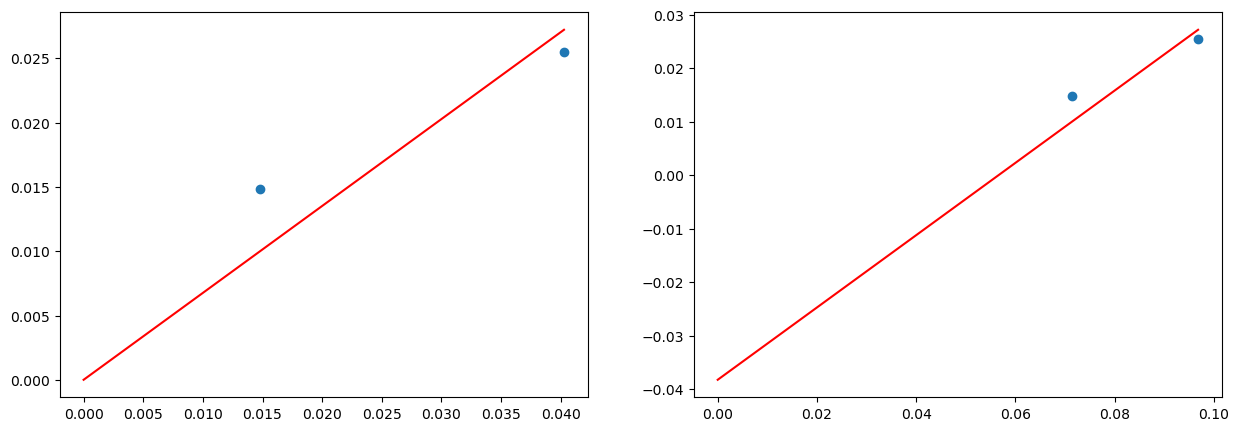

In [102]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.scatter(S, dSdt)
x = np.linspace(0, np.nanmax(S),100)
y = a_sel*x # (x+S_min)
ax1.plot(x, y, '-r')

ax2.scatter(S+S_min, dSdt)
x = np.linspace(0, np.nanmax(S+S_min),100)
y = a_sel*x - a_sel*S_min 
ax2.plot(x, y, '-r')